<a href="https://colab.research.google.com/github/lucasferreiraos/curso-aprendizado-de-maquina-na-pratica/blob/master/CNN_PUBG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUBG

O Playerunknown's Battle Grounds (PUBG) é um jogo eletrônico feito para PC, Xbox e mobile, do estilo battle royale. O jogo acontece em mapa aberto onde 100 jogadores saltam de um avião e a única missão deles é sobreviver. Para tal, eles podem coletar itens (armas, munição, bombas, itens de cura, capacetes, coletes, mochilas) e veículos que ficam distribuídos por todo o mapa. Durante a partida, um círculo de feixe azul (dentro do jogo, aqui no Brasil, é conhecido como "gás") vai se fechando para manter a área de jogo menor e forçar o confronto entre os jogadores. A área coberta pelo feixe azul causa dano e esse dano aumenta cada vez à medida em que o círculo vai ficando menor. A cada vez que o feixe "anda" é exibido em que ponto do mapa o círculo vai fechar. Esse novo ponto é comumente chamado de "safe". Quem ficar por último vence a partida. O jogo pode ser jogado tanto em primeira-pessoa quanto em terceira-pessoa. Os modos de jogo são solo, duo, squad de 3 pessoas e squad de 4 pessoas.

[Demosntração de uma partida de PUBG](https://www.youtube.com/watch?v=f-7iWtfx1uo&ab_channel=NetenhoCavalcante)

O dataset é de uma competição no Kaggle onde o desafio era construir o melhor modelo que conseguisse prever a probabilidade de um jogador vencer uma partida de acordo com suas estatísticas. [Link do dataset.](https://www.kaggle.com/c/pubg-finish-placement-prediction/data)


Variáveis:

- `DBNOs` - Número de jogadores inimigos batidos.
- `assists` - Número de jogadores inimigos que este jogador danificou que foram mortos por companheiros de equipe.
- `boosts` - Número de itens de boost utilizados.
- `damageDealt` - Dano total causado. Nota: o dano autoinfligido é subtraído.
- `headshotKills` - Número de inimigos abatidos com headshots.
- `heals` - Número de itens de cura utilizados.
- `Id` - ID do jogador
- `killPlace` - Classificação na partida do número de jogadores inimigos mortos.
- `killPoints` - Classificação externa do jogador baseada em mortes. (Pense nisso como um Elo - classificação onde apenas as mortes importam.) Se houver um valor diferente de -1 em rankPoints, então qualquer 0 em `killPoints` deve ser tratado como um `None`.
- `killStreaks` - Número máximo de jogadores inimigos mortos em um curto espaço de tempo.
- `kills` - Número de inimigos mortos.
- `longestKill` - Maior distância entre o jogador e o jogador morto no momento da morte. Isso pode ser enganoso, pois derrubar um jogador e fugir pode levar a uma estatística de morte mais longa.
- `matchDuration` - Duração da partida em segundos.
- `matchId` - ID para identificar partida. Não há partidas no conjunto de treinamento e teste.
- `matchType` - String que identifica o modo de jogo de onde vêm os dados. Os - modos padrão são “solo”, “duo”, “esquadrão”, “solo-fpp”, “duo-fpp” e “esquadrão-fpp”; outros modos são de eventos ou partidas personalizadas.
- `rankPoints` - Classificação do jogador semelhante a Elo. Esta classificação é inconsistente e está sendo descontinuada na próxima versão da API, então use com cuidado. Valor de -1 ocorre em `None`.
- `revives` - Número de vezes que este jogador reviveu companheiros de equipe.
- `rideDistance` - Distância total percorrida por veículos medida em metros.
- `roadKills` - Número de kills a bordo de um veículo.
- `swimDistance` - Distância total percorrida nadando em metros.
- `teamKills` - Número de vezes que esse jogador matou um aliado.
- `vehicleDestroys` - Número de veículos destruídos.
- `walkDistance` - Distância total percorrida caminhando em metros.
- `weaponsAcquired` - Número de armas adquiridas.
- `winPoints` - Classificação externa do jogador baseada em vitórias. (Pense nisso como um ranking Elo, onde apenas ganhar importa.) Se houver um valor diferente de -1 em `rankPoints`, então qualquer 0 em `winPoints` deve ser tratado como um `None`.
- `groupId` - ID para identificar um grupo em uma correspondência. Se o mesmo grupo de jogadores jogar em partidas diferentes, eles terão um `groupId` diferente a cada vez.
- `numGroups` - Número de grupos para os quais temos dados na partida.
- maxPlace - Pior colocação para a qual temos dados na partida. Isso pode não corresponder a numGroups, já que às vezes os dados pulam nas colocações.
- `winPlacePerc` - O alvo da previsão. Este é um posicionamento percentual de vitória, onde 1 corresponde ao 1º lugar e 0 corresponde ao último lugar na partida. É calculado fora de `maxPlace`, não `numGroups`, então é possível ter pedaços ausentes em uma correspondência.

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.wrappers.scikit_learn import KerasRegressor

from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dropout
)

In [2]:
data = pd.read_csv('/content/drive/My Drive/Datasets/pubg/pubg_train.csv')

In [3]:
print(f'Linhas: {data.shape[0]} - Colunas: {data.shape[1]}')

Linhas: 4446966 - Colunas: 29


Acabamos de ver que o dataset contém mais de 4 milhões de instâncias! Para ser mais exato: 4.446.966. Vamos seguir com o processo de limpeza apenas nos dados de treino, inicialmente, e depois vamos discutir possíveis abordagens para esses dados.

In [4]:
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
data.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [6]:
data.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

Como primeiro passo na limpeza dos dados, foi feito a verificação de ocorrência de valores nulos e a verificação dos tipos de cada coluna. Foi detectado um valor nulo e os tipos estão corretos. Mas antes de remover esse dado nulo, vale observar algumas informações sobre os atributos. Os atributos `killPoints`, `rankPoints` e `winPoints` tem considerações quanto a ocorrência do valor -1 e dão orientação da interpretação que deve ser feita. Vamos observar isso.

In [7]:
data.query('killPoints == -1').shape[0]

0

In [8]:
data.query('rankPoints == -1').shape[0]

1701810

In [9]:
data.query('winPoints == -1').shape[0]

0

Dos 3 atributos que tinham ressalvas sobre a interpretação do valor -1, somente a variável `rankPoints` apresenta a ocorrência desse valor. A sua descrição diz: Classificação do jogador semelhante a Elo. Esta classificação é inconsistente e está sendo descontinuada na próxima versão da API, então use com cuidado. Valor de -1 ocorre em “Nenhum”.

Levando em consideração a ressalva feita na descrição dio atributo `rankPoints` e a presença de um valor nulo no dataset, a abordagem será remover a coluna `rankPoints` e remover a linha que contém valor nulo

In [10]:
data.drop('rankPoints', axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

In [11]:
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [12]:
data.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

Depois da parte de limpeza, já estamos prontos para seguir com a parte da análise.

### Análise dos dados

Temos vários atributos aqui e, com eles, várias possibilidades de caminhos que podemos seguir e até mesmo possibilidades de diferentes tarefas. A atividade proposta originalmente na competição do Kaggle é de prever a probabilidade de um jogador (jogando solo ou em squad) de vencer a partida dado um conjunto de estatísticas de jogo do jogador (`winPlacePerc`). Você pode pensar nesse número como sendo a classificação final do jogador na partida, já que os valores estão entre 0 e 1 - ou entre 0 e 100 dividido por 100 - e o número de jogadores em uma partida é 100. Outra coisa que pode ser feita é mudar o atributo alvo para executar uma tarefa de classificação, mas vamos pensar nisso posteriormente.

No PUBG existem tipos de partida que são uma junção de composição de times (solo, duo, squad) e visualização de jogo (primeira pessoa e terceira pessoa). Opto por focar em analisar apenas dados de tipo de partida que contém primeira pessoa porque é um modo de visualização de jogo que tem um campo de visão limitado em relação ao modo de terceira pessoa, o que traz um nível de dificuldade maior na jogabilidade.

**PUBG em primeira pessoa**
![PUBG em primeira pessoa](https://www.windowsclub.com.br/wp-content/uploads/2018/01/pubg-fps.jpg)


**PUBG em terceira pessoa**
![PUBG em terceira pessoa](https://i.vimeocdn.com/video/687342755_640.jpg)

In [13]:
data.matchType.unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

A visualização padrão do jogo é em terceira pessoa. Veja que apenas os modos FPP são citados nos valores do atributo. Os modos que contém "flare" e "crash" são eventos e não farão parte da análise. Os modos que não contém "normal" são de partidas chamadas "ranqueadas" onde os jogadores acumulam pontos para subir na classificação geral do jogo.

In [14]:
match_modes = ['squad-fpp', 'solo-fpp', 'duo-fpp', 'normal-squad-fpp', 'normal-solo-fpp', 'normal-duo-fpp']

for mode in match_modes:
    print(f"{mode}: {data.query('matchType == @mode').shape[0]} mathces")

squad-fpp: 1756186 mathces
solo-fpp: 536761 mathces
duo-fpp: 996691 mathces
normal-squad-fpp: 17174 mathces
normal-solo-fpp: 1682 mathces
normal-duo-fpp: 5489 mathces


Considero válido olhar o número de registros em relação aos valores de algum atributo porque é possível ter uma noção de como os dados estão distribuídos de acordo com os valores.

### Histogramas

In [15]:
dt_squad_fpp = data.query("matchType == 'squad-fpp'")
dt_solo_fpp = data.query("matchType == 'solo-fpp'")
dt_duo_fpp = data.query("matchType == 'duo-fpp'")
dt_normal_squad_fpp = data.query("matchType == 'normal-squad-fpp'")
dt_normal_solo_fpp = data.query("matchType == 'normal-solo-fpp'")
dt_normal_duo_fpp = data.query("matchType == 'normal-duo-fpp'")

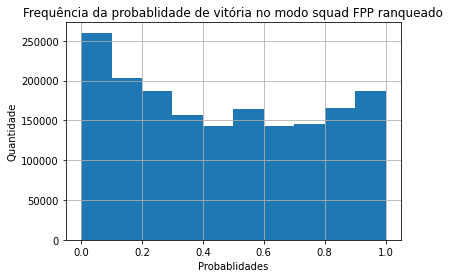

In [16]:
plt.hist(dt_squad_fpp.winPlacePerc, 10)
plt.title('Frequência da probablidade de vitória no modo squad FPP ranqueado')
plt.xlabel('Probablidades')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

Esse histograma nos mostra que temos um maior concentração de registros de jogadores mais à direita do gráfico, na faixa de valores entre 0.0 e 0.2 e depois a distribuição fica mais equilibrada.

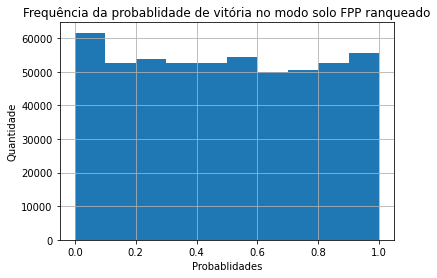

In [17]:
plt.hist(dt_solo_fpp.winPlacePerc, 10)
plt.title('Frequência da probablidade de vitória no modo solo FPP ranqueado')
plt.xlabel('Probablidades')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

Aqui a distribuição está bem mais bem mais equilibrada com um pequeno pico no primeiro bloco.

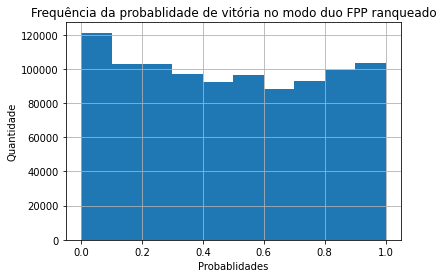

In [18]:
plt.hist(dt_duo_fpp.winPlacePerc, 10)
plt.title('Frequência da probablidade de vitória no modo duo FPP ranqueado')
plt.xlabel('Probablidades')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

Aqui a distribuição tem um comportamento mais próximo ao primeiro histograma, com uma concentração maior no início e uma leve descida na região central e volta a inclinar levemente na extrema esquerda.

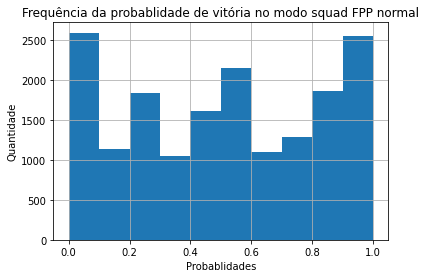

In [19]:
plt.hist(dt_normal_squad_fpp.winPlacePerc, 10)
plt.title('Frequência da probablidade de vitória no modo squad FPP normal')
plt.xlabel('Probablidades')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

Nossa... esse histograma já mostra uma distribuição bem diferente dos primeiros três gráficos. Esse é o primeiro gráfico dos modos de jogo para partidas que não são ranqueadas.

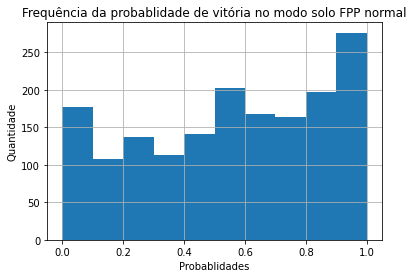

In [20]:
plt.hist(dt_normal_solo_fpp.winPlacePerc, 10)
plt.title('Frequência da probablidade de vitória no modo solo FPP normal')
plt.xlabel('Probablidades')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

Já nesse histograma temos uma distribuição um pouco menos instável em relação ao gráfico anterior.

O último gráfico apresenta uma menor irregularidade mas seguindo o mesmo padrão de distribuição dos últimos dois gráficos.

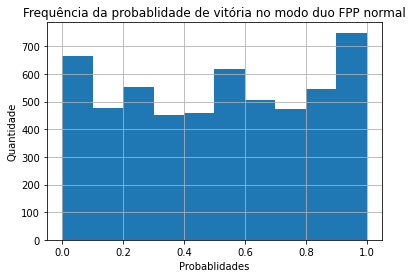

In [21]:
plt.hist(dt_normal_duo_fpp.winPlacePerc, 10)
plt.title('Frequência da probablidade de vitória no modo duo FPP normal')
plt.xlabel('Probablidades')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

Nos histogramas conseguimos observar a distribuição dos possíveis valores do atributo alvo para cada valor do atributo. E você pode perfeitamente me questionar: mas por quê você fez isso? Em primeiro lugar, observando os valores do atributo alvo com maior frequência, eu posso ter uma visão geral dos dados e fiz isso com os tipos de partida porque um deles vai ser escolhido para ser utilizado no restante do pipe line. Uma coisa a ser ressaltada é que, independente do tipo de partida, cada registro se refere a uma performance de um jogador.

De maneira geral, segundo o que os histogramas nos mostram, é que as partidas ranqueadas (3 primeiros histogramas) tendem a ser mais equilibradas que as partidas normais (3 últimos histogramas). Isso se deve ao fato de que apenas jogadores com um certo nível de experiência e habilidade jogam partidas ranqueadas, até porque é necessário atingir um determinado nível dentro jogo para ter acesso às partidas ranqueadas; enquanto que as partidas normais comportam jogadores de diferentes níveis, incluindo iniciantes.

### Discutindo a abordagem de analisar um modo de partida em específico

Antes de escolher o tipo da partida que vai ser analisado a partir de agora, vale comentar que esse trabalho poderia ser feito sem a abordagem que será utilizada aqui. Contudo, os modos de jogo apresentam dinâmicas diferentes que são inerentes à sua natureza e isso reflete em como o jogador atua durante uma partida, seja jogando solo ou em grupo, seja jogando por diversão nas partidas normais ou para competir nas ranqueadas e em eventos.

Dito isso, vamos seguir analisando o modo squad FPP ranqueado. O modo squad é um modo de jogo que requer um nível mais elevado de estratégia se comparado com o modo solo, pois você tem várrias possibilidades de abordagem para avançar em cima do squad inimigo, você tem a possibilidade de curar um parceiro quando ele é derrubado, pode utilizar várias técnicas de distração para efetuar um avanço, etc. Então analisar esses atributos pela óptica do modo squad traz um desafio a mais para podermos entender o que cada atributo nos diz.

Vale lembrar que o modo squad no PUBG pode ser um squad com 3 jogadores (que dá 99 jogadores no mapa) ou um squad com 4 jogadores e essa opção pode ser escolhida pelo jogador antes de iniciar a partida. Quando é selecionado o modo squad com 3 jogadores por grupo, você joga em um mapa onde todos os squads possuem 3 jogadores e, de forma análoga, o mesmo acontece quando você seleciona o modo squad com 4 jogadores.

### Próximas etapas

Uma das coisas que poderia ser feita nesse ponto é analisar correlações entre variáveis, mas o que pode ser feito, que também é interessante, é rodar um modelo com todos os atributos para depois, quem sabe, trabalhar em um processo de selecionar variáveis e, antes disso, temos que normalizar os dados e organizar os dados.

Abaixo já estamos começando a divisão dos subsets e retirando as variáveis que não serão úteis para o modelo.

In [22]:
X = dt_squad_fpp.drop(['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc'], axis=1)
y = dt_squad_fpp.winPlacePerc

In [23]:
X.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,28,26,0,0.0000,0,0.00,0,0,244.8,1,1466
1,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,26,25,0,0.0045,0,11.04,0,0,1434.0,5,0
3,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,31,30,0,0.0000,0,0.00,0,0,202.7,3,0
5,0,0,100.00,1,1,0,44,0,1,1,18.44,1395,28,28,0,0.0000,0,0.00,0,0,34.7,1,0
6,0,0,0.00,0,0,0,96,1262,0,0,0.00,1316,28,28,0,0.0000,0,0.00,0,0,13.5,1,1497


In [24]:
y.head()

0    0.4444
1    0.6400
3    0.1667
5    0.0370
6    0.0000
Name: winPlacePerc, dtype: float64

### Reescalando os dados e dividindo os subsets

In [28]:
X = (X - X.min()) / (X.max() - X.min())
y = (y - y.min()) / (y.max() - y.min())

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [30]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1404948, 23) (351238, 23) (1404948,) (351238,)


In [34]:
X_train = np.expand_dims(X_train, axis=2)
X_train.shape

(1404948, 23, 1)

### Uma forma diferente de implementar uma CNN

Vale a pena comentar o que acontece nas duas células seguintes. Em uma outra ocasião eu precisei criar uma rede neural para trabalhos de regressão e durante minhas pesquisas eu descobri que o `keras` possui uma interface que consome recursos do `sklearn` (assim como `sklearn` usa o `tensorflow` por baixo dos panos) que está no módulo `keras.wrappers.scikit_learn.KerasRegressor`. Então, para podermos criar uma CNN para regressão, temos que:

1 - Encapsular nossa arquitetura em uma função, que aqui eu chamo de `cnn_model`

2 - Instanciar a classe `KerasRegressor` passando como parâmetros a função que encapsula a nossa arquitetura e o número de épocas de treinamento. Você pode passar outros parâmetros que o modelo de regressão original do `sklearn` suporta. [See the docs](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor).

Depois disso, você treinar e avaliar o seu modelo da forma que você sempre fez.

In [43]:
 def cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=10, kernel_size=2, activation='relu', input_shape=(23, 1)))
    model.add(Conv1D(filters=10, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')

    return model

In [44]:
cnn_regressor = KerasRegressor(build_fn=cnn_model, epochs=10)

In [45]:
cnn_regressor.fit(X_train, y_train)

Epoch 1/10
43905/43905 [==============================] - 116s 3ms/step - loss: 0.0091
Epoch 2/10
43905/43905 [==============================] - 122s 3ms/step - loss: 0.0081
Epoch 3/10
43905/43905 [==============================] - 114s 3ms/step - loss: 0.0079
Epoch 4/10
43905/43905 [==============================] - 113s 3ms/step - loss: 0.0079
Epoch 5/10
43905/43905 [==============================] - 112s 3ms/step - loss: 0.0078
Epoch 6/10
43905/43905 [==============================] - 106s 2ms/step - loss: 0.0078
Epoch 7/10
43905/43905 [==============================] - 100s 2ms/step - loss: 0.0078
Epoch 8/10
43905/43905 [==============================] - 103s 2ms/step - loss: 0.0078
Epoch 9/10
43905/43905 [==============================] - 102s 2ms/step - loss: 0.0077
Epoch 10/10
43905/43905 [==============================] - 101s 2ms/step - loss: 0.0077


In [47]:
X_test = np.expand_dims(X_test, axis=2)

In [48]:
cnn_regressor_pred = cnn_regressor.predict(X_test)

### Avaliando o modelo

Para a avaliação do modelo vamos utilizar as métricas tradicionais para modelos de regressão:

- MAE: Erro Médio Absoluto
- MSE: Erro Médio Quadrático
- RMSE: Raiz do Erro Médio Quadrático
- MAPE: Porcentagem do Erro Médio Absoluto

In [52]:
print('MAE - Erro Médio Absoluto')
print(f'CNN: {round(mean_absolute_error(y_test, cnn_regressor_pred) ,2)}')

MAE - Erro Médio Absoluto
CNN: 0.07


In [53]:
print('MSE - Erro Médio Quadrático')
print(f'CNN: {round(mean_squared_error(y_test, cnn_regressor_pred), 2)}')

MSE - Erro Médio Quadrático
CNN: 0.01


In [54]:
print('RMSE - Raiz do Erro Médio Quadrático')
print(f'CNN: {round(np.sqrt(mean_absolute_error(y_test, cnn_regressor_pred)), 2)}')

RMSE - Raiz do Erro Médio Quadrático
CNN: 0.26


In [55]:
def mean_absolute_percentage_error(y_test, predict):
    soma = 0
    for i in range(len(y_test)):
        soma += abs((y_test[i] - predict[i]) / y_test[i]) * 100
    media_erro = soma / len(y_test)
    return media_erro

In [59]:
y_test_no_index = y_test.reset_index(drop=True)

print('MAPE - Porcentagem do Erro Médio Absoluto')
print(f'CNN: {round(mean_absolute_percentage_error(y_test_no_index+1, cnn_regressor_pred+1)**(1/2), 2)}')

MAPE - Porcentagem do Erro Médio Absoluto
CNN: 2.15


### Discutindo resultados e o trabalho

|Modelo/Métrica|MAE |MSE |RMSE|MAPE|
|--------------|----|----|----|----|
|CNN           |0.07|0.01|0.26|2.15|

Diante do resultados é possível perceber que o modelo, com uma configuração simples e com 10 épocas de treinamento, obteve resultados satisfatórios levando em consideração apenas o que as métricas nos dizem.

Devemos levar em consideração que não estamos fazendo comparação com outro modelo ou outra arquitetura de CNN; não utlizamos otimização de parâmetros e não utilizamos seleção de atributos.

Alguns pontos em relação os dados devem ser discutidos:

- O dataset original contém um arquivo próprio de testes (caraceterística comum dos datasets de competições do Kaggle), mas optamos por criar os subsets apenas com o arquivo de treino. Isso pode ser um fator que tenha tido influência nos resultados.

- A tarefa original do desfaio no Kaggle é para prever a probabilidade de um jogador vencer uma partida em qualquer modo de jogo, porém aqui nos restringimos apenas ao modo squad FPP ranqueado.

- Poderíamos mudar o nosso target para podermos adequar nossos dados para uma tarefa de classificação.